#Student Name: 
#ECE 595 Machine Learning II
#Project 4: Adversarial Machine Learning - Student Code

In [1]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

    100% |████████████████████████████████| 81kB 2.6MB/s ta 0:00:011
    100% |████████████████████████████████| 51kB 3.6MB/s eta 0:00:01
Exception:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/opt/anaconda3/lib/python3.6/site-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/opt/anaconda3/lib/python3.6/site-packages/pip/req/req_set.py", line 784, in install
    **kwargs
  File "/opt/anaconda3/lib/python3.6/site-packages/pip/req/req_install.py", line 851, in install
    self.move_wheel_files(self.source_dir, root=root, prefix=prefix)
  File "/opt/anaconda3/lib/python3.6/site-packages/pip/req/req_install.py", line 1064, in move_wheel_files
    isolated=self.isolated,
  File "/opt/anaconda3/lib/python3.6/site-packages/pip/wheel.py", line 345, in move_wheel_files
    clobber(source, lib_dir, True)
  File "/opt/anaconda3/li

In [7]:
#Import necessary packages
import tensorflow.compat.v1 as tf
from keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout, Reshape, LSTM, InputLayer
from keras import backend
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2
import pandas as pd


#Part 1: Training a target classifier

In [3]:
# Load data MNIST data and normalize to [0, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = (data_train)/255.; print(tf.shape(data_train))
data_test = (data_test)/255; print(tf.shape(data_test))

#Reshape training and testing data into 784-dimensional vectors 
data_train = tf.reshape(data_train,[-1,28,28,1]); print(tf.shape(data_train))
data_test = tf.reshape(data_test,[-1,28,28,1]); print(tf.shape(data_train))

#Convert integer labels for training and testing data into one-hot vectors 
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10);print(tf.shape(labels_train))
labels_test  = keras.utils.np_utils.to_categorical(labels_test , num_classes=10);print(tf.shape(labels_test))

num_samples=5000; n=28; num_channels=1; num_classes=10;

#Create classifier architecture, compile it, and train it
def CNN():
    model = Sequential()

    model.add(InputLayer(input_shape=(n,n,num_channels)))
    model.add(Conv2D(256, kernel_size=(3,3), 
                     activation='relu',input_shape=(n,n,num_channels)))
    model.add(Dropout(.3))
    model.add(MaxPooling2D(pool_size=(2,2), strides=None, 
                           padding='Valid', data_format=None))
    model.add(Conv2D(128, kernel_size=(3,3), 
                     activation='relu',input_shape=(n,n,num_channels)))
    model.add(Dropout(.3))
    model.add(MaxPooling2D(pool_size=(2,2), strides=None, 
                           padding='Valid', data_format=None))
    model.add(Flatten())
    model.add(Dense(100,activation='relu',kernel_initializer='normal'))
    model.add(Dense(100,activation='relu',kernel_initializer='normal'))
    model.add(Dense(num_classes,activation='softmax'))      
    return model

#Create instance of CNN model graph
model = CNN()

#Compile model using an appropriate loss and optimizer algorithm
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

#Train the model and assign training meta-data to a variable
model_mdata =  model.fit(data_train, labels_train, epochs=100,
                        validation_data=(data_test, labels_test),
                        batch_size=64,
                        shuffle=True)
hist_df = pd.DataFrame(model_mdata.history) 
CNN_dropout_hidden_file = 'CNN_mdata.csv'
with open(CNN_dropout_hidden_file, mode='w') as f:
    hist_df.to_csv(f)

#Print accuracy of model on testing set after training 
scores_dropout_hidden = model.evaluate(data_train, labels_train)
model.save("mnist_classified_CNN.h5")




tf.Tensor([60000    28    28], shape=(3,), dtype=int32)
tf.Tensor([10000    28    28], shape=(3,), dtype=int32)
tf.Tensor([60000    28    28     1], shape=(4,), dtype=int32)
tf.Tensor([60000    28    28     1], shape=(4,), dtype=int32)
tf.Tensor([60000    10], shape=(2,), dtype=int32)
tf.Tensor([10000    10], shape=(2,), dtype=int32)
Epoch 1/100
938/938 [==============================] - 187s 200ms/step - loss: 0.2515 - accuracy: 0.9226 - val_loss: 0.1143 - val_accuracy: 0.9727
Epoch 2/100
938/938 [==============================] - 187s 200ms/step - loss: 0.1120 - accuracy: 0.9669 - val_loss: 0.1276 - val_accuracy: 0.9650
Epoch 3/100
938/938 [==============================] - 186s 198ms/step - loss: 0.1066 - accuracy: 0.9688 - val_loss: 0.0699 - val_accuracy: 0.9814
Epoch 4/100
938/938 [==============================] - 187s 200ms/step - loss: 0.0979 - accuracy: 0.9724 - val_loss: 0.0837 - val_accuracy: 0.9787
Epoch 5/100
938/938 [==============================] - 186s 198ms/step - los

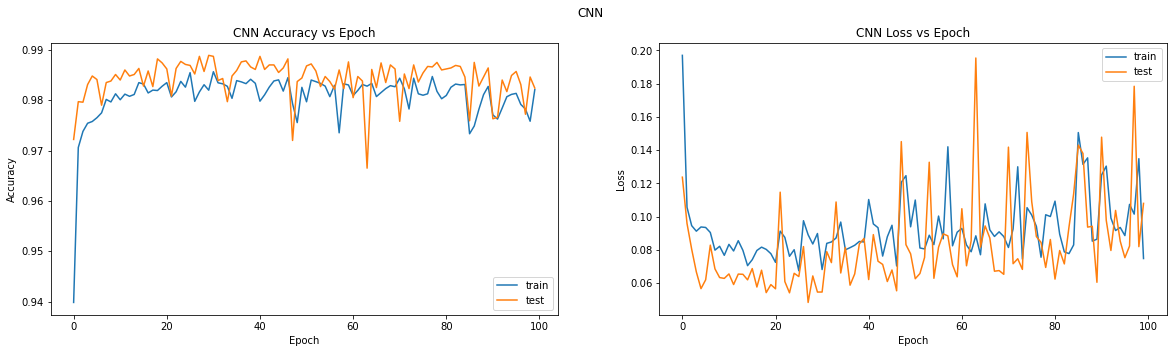

    Unnamed: 0      loss  accuracy  val_loss  val_accuracy
0            0  0.197056  0.939833  0.123725        0.9722
1            1  0.105596  0.970600  0.095858        0.9797
2            2  0.094559  0.973800  0.080390        0.9796
3            3  0.091231  0.975417  0.066722        0.9831
4            4  0.093768  0.975767  0.056649        0.9848
..         ...       ...       ...       ...           ...
95          95  0.088580  0.981350  0.075282        0.9857
96          96  0.107364  0.979150  0.082272        0.9831
97          97  0.101496  0.978233  0.178436        0.9772
98          98  0.134864  0.975817  0.081924        0.9846
99          99  0.074765  0.982083  0.107964        0.9824

[100 rows x 5 columns]


In [12]:
def plotting(history,title):
  plt.figure(figsize=(20,5))
  plt.subplot(121)
  plt.plot(history.accuracy)
  plt.plot(history.val_accuracy)
  plt.title('CNN Accuracy vs Epoch'); plt.ylabel('Accuracy'); plt.xlabel('Epoch')
  plt.legend(['train','test']); 
  plt.subplot(122);
  plt.plot(history.loss)
  plt.plot(history.val_loss)
  plt.title('CNN Loss vs Epoch'); plt.ylabel('Loss'); plt.xlabel('Epoch')
  plt.legend(['train','test']); plt.suptitle(title); plt.show();
#Plot loss vs epoch
CNN_file = 'CNN_mdata.csv'
history=pd.read_csv(CNN_file); 
plotting(history,'CNN')
print(history)

In [13]:
#Print accuracy of classifier on MNIST testing data
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

Accuracy: 98.74%


In [5]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
model = tf.keras.models.load_model('mnist_classified_CNN.h5')

# Check its architecture
new_model.summary()
# load('mnist_classified_CNN.h5')
#Get TensorFlow Session to pass into Cleverhans modules
sess = tf.compat.v1.keras.backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 256)       2560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       295040    
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)             

#Part 2: The Fast Gradient Method (FGM)

In [6]:
#Implementing the FGSM attack
backend.set_learning_phase(0)

#FGM Instance on trained classifier from Part 1
#FILL THIS IN
fgm = FastGradientMethod(wrap, sess=sess)

#Attack parameters
#FILL THIS IN
fgm_params = { 'eps': 0.25, 'clip_min': 0.0, 'clip_max': 1.0}

#Generate adversarial data
#FILL THIS IN
fgm_data = fgm.generate_np(data_test, **fgm_params)

#Evaluate accuracy on target classifier 
#FILL THIS IN
# backend.set_learning_phase(0)
[test_loss_fgm, test_acc_fgm] = model.evaluate(fgm_data, labels_test, batch_size = 512)
print("Test Accuracy: {:0.2f}%".format(test_acc_fgm*100))

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: module 'tensorflow' has no attribute 'GraphKeys'

In [0]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
#FILL THIS IN

#Attack parameters
#FILL THIS IN

#Generate adversarial data
#FILL THIS IN

#Evaluate accuracy on target classifier 
#FILL THIS IN


In [0]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN

In [0]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer
#FILL THIS IN

In [0]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
#FILL THIS IN

# Obtain reconstruction errors on training set and determine a threshold 
#FILL THIS IN

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = error.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
#FILL THIS IN

# Calculate error of adversarial testing set
#FILL THIS IN

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
#FILL THIS IN

# Print number of true positive samples
#FILL THIS IN  

# Determine false positives on benign testing set
#FILL THIS IN 


# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
#FILL THIS IN 
    
# Print number of false positive samples
#FILL THIS IN   

#Part 3: Projected Gradient Descent

In [0]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
#FILL THIS IN

#Generate adversarial data
#FILL THIS IN

#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN

In [0]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN 

In [0]:
#Implementing the adversarial training defense
#FILL THIS IN

In [0]:
#Using the defense to evaluate the accuracy of the perturbed data
#FILL THIS IN 

#Part 4: Carlini and Wagner Attack

In [0]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
#FILL THIS IN


#Attack parameters
#FILL THIS IN


#Generate adversarial data
#FILL THIS IN


#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN

In [0]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN 

In [0]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

#Transform perturbed CW data using the subspace from the original training data
#FILL THIS IN 

# create model for PCA
def pca_model():
    model = Sequential()
    
    #FILL THIS IN 

    return model

#Create model graph, compile it, and train it using pca_train lables_train 
#FILL THIS IN 

In [0]:
#Using the defense (and comparing to baseline accuracy)
#FILL THIS IN 

#Part 5: DeepFool 

In [0]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
#FILL THIS IN


#Attack parameters
#FILL THIS IN


#Generate adversarial data
#FILL THIS IN


#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN

In [0]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN

In [0]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
df_attack_data_train = deepfool.generate_np(data_train, **fgm_params)
data_total_train = np.concatenate([df_attack_data_train, data_train])

#Create and train DAE graph
#FILL THIS IN

In [0]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
#FILL THIS IN

#Evaluate accuracy of FGM samples after denoising 
#FILL THIS IN

In [0]:
#Show ten samples of adversarial samples after denoising
#FILL THIS IN